# 1. Dataset
Download the movieLens dataset:
http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

The data are represented by 100836 rows and 4 columns called userId, movieId, rating et timestamp. We will work
only with the 3 first columns which are userId, movieId, rating. These data are made by 610 users rating more or less 10
movies each among 9724 movies.

In [1]:
import os
import requests
import zipfile

# Get the current working directory
current_directory = os.getcwd()

# Set the path for the 'data' directory
data_directory = os.path.join(current_directory, 'data')
os.makedirs(data_directory, exist_ok=True)

# URL and file paths
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
filename = "ml-latest-small.zip"
unzipped_folder_name = filename.replace('.zip', '')
path_zip = os.path.join(data_directory, filename)
path_unzipped = os.path.join(data_directory, unzipped_folder_name)

# Check if the unzipped folder already exists
if not os.path.exists(path_unzipped):
    print(f"Folder {unzipped_folder_name} not found. Downloading and unzipping...")

    # Download the zip file
    response = requests.get(url)
    with open(path_zip, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Unzip the file
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
    print("Unzipping completed.")

    # Delete the zip file
    os.remove(path_zip)
    print("Zip file deleted.")
else:
    print(f"Folder {unzipped_folder_name} already exists.")


Folder ml-latest-small not found. Downloading and unzipping...
Download completed.
Unzipping completed.
Zip file deleted.


In [2]:
import pandas as pd

ratings_filename = "ratings.csv"
path_ratings = os.path.join(path_unzipped, ratings_filename)
ratings = pd.read_csv(path_ratings)
ratings.tail(5)


,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [3]:
from scipy.sparse import coo_matrix

sparse_matrix = coo_matrix((ratings['rating'], (ratings['movieId'], ratings['userId'])))

# csr for slicing capabilities
sparse_matrix_csr = sparse_matrix.tocsr()

# Find rows and columns with non-zero sums (i.e., where there are ratings)
rows_with_ratings = sparse_matrix_csr.sum(axis=1).A1 != 0
cols_with_ratings = sparse_matrix_csr.sum(axis=0).A1 != 0
ratings_matrix = sparse_matrix_csr[rows_with_ratings, :][:, cols_with_ratings]

print(ratings_matrix.shape)

(9724, 610)


# 2. Minimal rank choice of a matrix
Determine graphically and empirically the rank r of the matrix movies×users as it follows :
For the matrix completion problem, in the first step of our SVP method, we compute singular values incrementally till we find
no more significant gap between singular values : the gap between the rth and r + 1th singular value should be small compared
to the first ones.

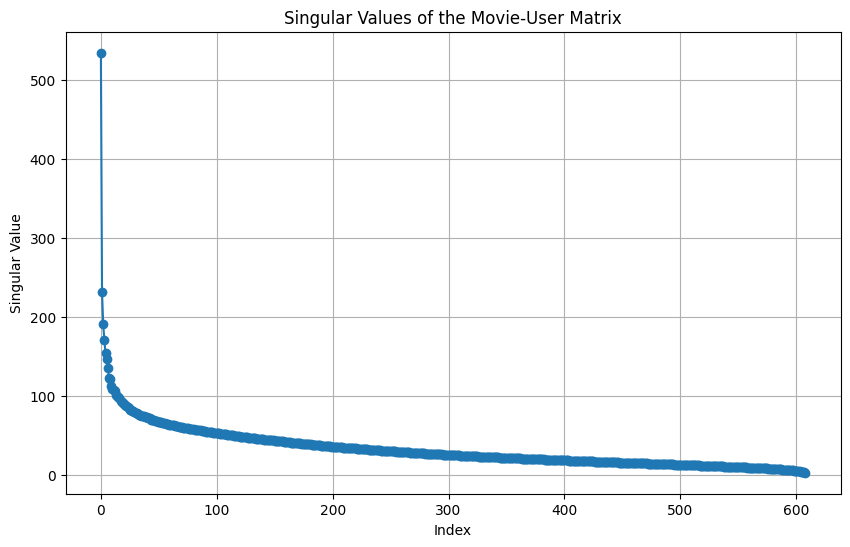

In [4]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# k, number of singular values, so minimum of the shape
k = min(ratings_matrix.shape) - 1 
u, s, vt = svds(ratings_matrix, k=k)

# Values in descending order, order of importance 
singular_values = sorted(s, reverse=True)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, 'o-')
plt.title("Singular Values of the Movie-User Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid()
plt.show()


In [5]:
import numpy as np

differences = -np.diff(singular_values)

# Criterion for a significant gap
significance = .01

threshold = significance * differences[0]
significant_rank = np.argmax(differences < threshold) + 1

print(f"The significant rank is: {significant_rank}. \nThis rank is determined as the point where the gap between "
      f"consecutive singular values is less than {significance * 100:.2f}% of the first gap.")

The significant rank is: 8. 
This rank is determined as the point where the gap between consecutive singular values is less than 1.00% of the first gap.


In [6]:
import numpy as np
from numpy.linalg import svd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.sparse import find, csr_matrix, lil_matrix

def compute_residuals(X, ratings, indices):
    """
    Compute residuals for known entries.
    """
    rows, cols = indices
    residual_values = ratings - X[rows, cols]
    return residual_values

def perform_svd_and_reconstruct(matrix, rank=None, cut_off=None, return_bases=False):
    """
    Perform SVD on the given matrix and reconstruct it using specified rank.
    """
    if rank is None:
        U, sigma, Vt = svd(matrix, full_matrices=False)
    else:
        U, sigma, Vt = svds(matrix, k=rank)
    
    if cut_off is not None:
        sigma = soft_threshold(sigma, cut_off)
        
    reconstructed_matrix = U @ np.diag(sigma) @ Vt
    
    if return_bases:
        bases = [csr_matrix(np.outer(U[:, k], Vt[k, :])) for k in range(rank)]
        return reconstructed_matrix, bases
    
    return reconstructed_matrix

def update_matrix(X, updates, indices):
    """
    Efficiently update matrix X at specified indices with given updates.
    """
    rows, cols = indices
    X[rows, cols] += updates
    return X

def compute_rmse(residuals):
    """
    Compute RMSE for known entries.
    """
    return np.sqrt(np.mean(residuals ** 2))


def soft_threshold(x, lambda_val):
    """
    Apply soft-thresholding to the input array.
    
    Parameters:
    - x: input array.
    - lambda_val: thresholding parameter.
    
    Returns:
    - thresholded array.
    """
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)




# 3. Implementation and application
Implement and test on the dataset the 3 approaches proposed below :

## 3.1 Singular Value Projection algorithm

Iteration 32, RMSE: 0.9493763406964911


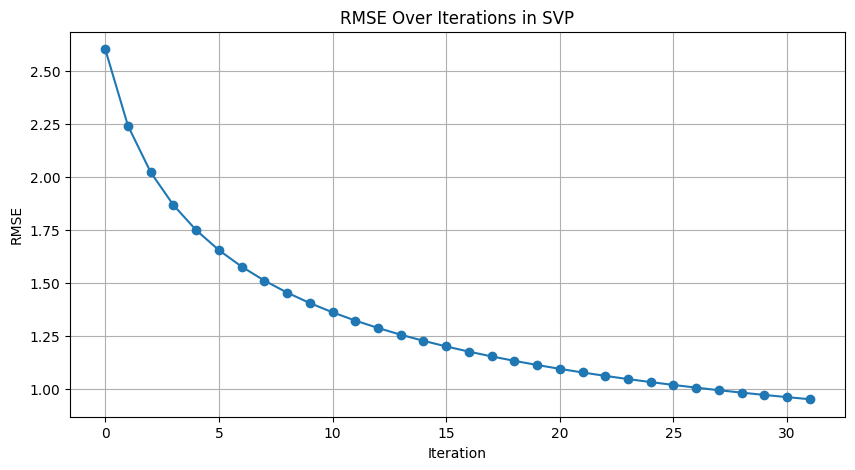

Best RMSE obtained: 0.9493763406964911


In [10]:
def svp_algorithm(ratings_matrix, rank, epsilon=0.01):
    """
    Singular Value Projection (SVP) Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    X_list = [X_hat]
    best_rmse = float('inf')
    rmse_values = []
    convergence = False
    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        X_hat[rows, cols] += residuals
        X_hat = perform_svd_and_reconstruct(X_hat, rank=rank)
        X_list.append(X_hat)

        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        
        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)
        
        if len(rmse_values) > 1 and rmse_current > rmse_values[-2] - epsilon:
            convergence = True

        
        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}', end='')
    print()

    return best_X_hat, rmse_values, X_list

X_hat, rmse_values, X_list = svp_algorithm(ratings_matrix, significant_rank)

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in SVP')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE and the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

376


## 3.2. Convex relaxation algorithm
Note that the parameter λ should be carefully chosen. Note also that a gradient step size can be put in step 3, in the aim to
improve the convergence of the algorithm.

Iteration 18, RMSE: 2.0490082330459596


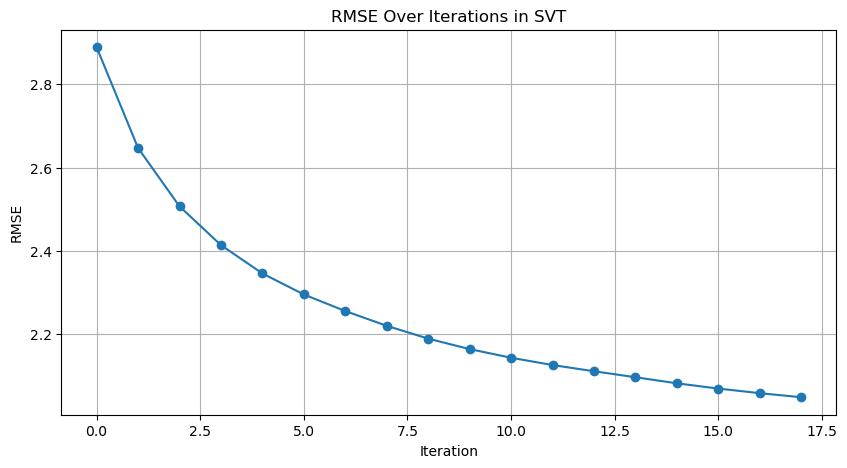

Best RMSE obtained: 2.0490082330459596


In [8]:
def svt_algorithm(ratings_matrix, cut_off, step_size=1.0, epsilon=0.01):
    """
    Singular Value Thresholding (SVT) Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    best_rmse = float('inf')
    rmse_values = []
    convergence = False
    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        X_hat[rows, cols] += step_size * residuals
        X_hat = perform_svd_and_reconstruct(X_hat, cut_off=cut_off)
        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        

        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)

        if len(rmse_values) > 1 and rmse_current > rmse_values[-2] - epsilon:
            convergence = True
        
        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}', end='')
    print()

    return best_X_hat, rmse_values

cut_off = 100
X_hat, rmse_values = svt_algorithm(ratings_matrix, cut_off)


# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in SVT')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE and the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

## 3.3. ADMiRA algorithm
The choice of the parameter r will be the same as the ones defined in question 2. The notations are the same than in the course
notes.

Iteration 9, RMSE: 1.2076618462959856, Relative Error: 0.33055306460071443


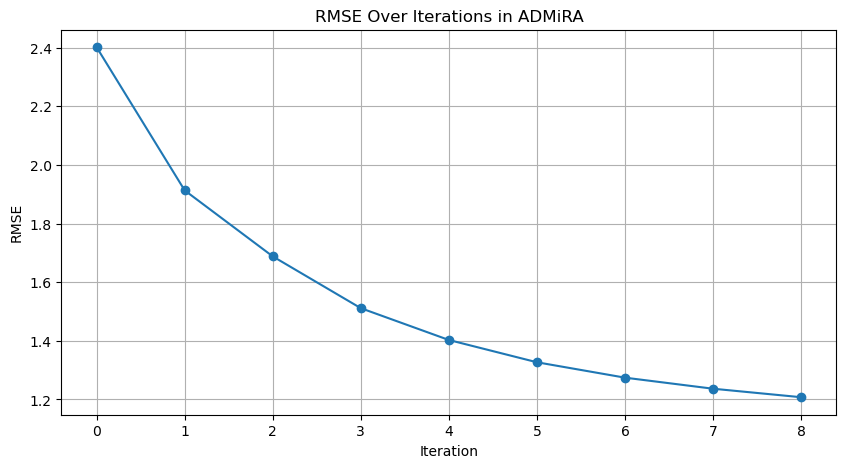

Best RMSE obtained: 1.2076618462959856


In [9]:
def admira_algorithm(ratings_matrix, rank, epsilon=0.01):
    """
    ADMiRA Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    norm_y = np.linalg.norm(ratings)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    best_rmse = float('inf')
    Psi_matrices = []
    rmse_values = []
    relative_errors = [] 
    convergence = False

    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        residual_matrix = np.zeros(ratings_matrix.shape)
        residual_matrix[rows, cols] = residuals

        U, sigma, Vt = svds(residual_matrix, 2 * rank)
        Psi_prime = [csr_matrix(np.outer(U[:, k], Vt[k, :])) for k in range(2 * rank)]
        Psi_matrices.extend(Psi_prime)

        # No Orthogonalization
        Psi_known = np.vstack([psi[rows, cols].A1 for psi in Psi_matrices])
        coefficients, _, _, _ = np.linalg.lstsq(Psi_known.T, ratings, rcond=None)

        # Orthogonalize 
        # Potentially not needed due to the orthogonality of the residuals with the previous prediction
        # Q, R = np.linalg.qr(Psi_known.T)
        # Psi_orthogonalized = Q.T
        # coefficients, _, _, _ = np.linalg.lstsq(Psi_orthogonalized.T, ratings, rcond=None)
        
        X_e = sum(psi.multiply(coeff) for psi, coeff in zip(Psi_matrices, coefficients))
        X_hat, Psi_matrices = perform_svd_and_reconstruct(X_e, rank, return_bases=True)

        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        
        # Compute the norm of residuals
        norm_residuals = np.linalg.norm(residuals)

        relative_errors.append(norm_residuals / norm_y)

        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)
        
        if len(rmse_values) > 1 and (relative_errors[-1] > relative_errors[-2] - epsilon):
            convergence = True

        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}, Relative Error: {relative_errors[-1]}', end='')
    print()

    return best_X_hat, rmse_values

X_hat, rmse_values = admira_algorithm(ratings_matrix, significant_rank)

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in ADMiRA')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

In [10]:
import numpy as np
from scipy.sparse import find, csr_matrix
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def create_folds(ratings_matrix, num_folds):
    """Create k folds by randomly hiding a portion of the ratings."""
    rows, cols, ratings = find(ratings_matrix)
    indices = np.arange(len(ratings))
    np.random.shuffle(indices)

    # Adjust the number of folds if it's larger than the dataset size
    num_folds = min(num_folds, len(ratings))
    
    fold_size = len(ratings) // num_folds
    remainder = len(ratings) % num_folds
    start_idx = 0
    folds = []

    for i in range(num_folds):
        if i < remainder:
            # Distribute the remainder among the first few folds
            end_idx = start_idx + fold_size + 1
        else:
            end_idx = start_idx + fold_size

        test_indices = indices[start_idx:end_idx]
        start_idx = end_idx

        # Create the training set by hiding the test ratings
        train_set = deepcopy(ratings_matrix)
        train_set[rows[test_indices], cols[test_indices]] = 0

        # Create the test set
        test_set = csr_matrix((ratings[test_indices], (rows[test_indices], cols[test_indices])), shape=ratings_matrix.shape)

        folds.append((train_set, test_set))

    return folds


def train_and_evaluate_model(train_set, test_set, algorithm, return_train=False, **params):
    """ Train the model using the specified algorithm and parameters, and evaluate on the test set. """
    if algorithm == 'admira':
        X_hat, train_scores = admira_algorithm(train_set, **params)
    elif algorithm == 'svp':
        X_hat, train_scores = svp_algorithm(train_set, **params)
    elif algorithm == 'svt':
        X_hat, train_scores = svt_algorithm(train_set, **params)
    else:
        raise ValueError("Invalid algorithm specified")

    # Compute RMSE on test set
    rows, cols, ratings = find(test_set)
    residuals = compute_residuals(X_hat, ratings, (rows, cols))
    rmse = compute_rmse(residuals)    

    if return_train:
        return rmse, train_scores
    return rmse


In [11]:
def cross_validate(ratings_matrix, algorithm, param_grid, num_folds=5):
    folds = create_folds(ratings_matrix, num_folds)

    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        scores = []

        for train_set, test_set in folds:
            score = train_and_evaluate_model(train_set, test_set, algorithm, **params)
            print(f'Evaluation, Fold: {len(scores)} RMSE: {score}, parameters: {params=}')
            scores.append(score)

        avg_score = sum(scores) / len(scores)

        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    return best_params, best_score


In [12]:
from scipy.sparse import coo_matrix

def split_data(ratings_matrix, test_size=0.1):
    """ Split the data into training and test sets. """
    rows, cols, ratings = find(ratings_matrix)
    num_ratings = len(ratings)
    num_test = int(num_ratings * test_size)
    
    indices = np.arange(num_ratings)
    np.random.shuffle(indices)
    
    test_indices = indices[:num_test]
    
    train_set = deepcopy(ratings_matrix)
    
    # Set test indices in the training set to zero and vice versa
    train_set[rows[test_indices], cols[test_indices]] = 0
    train_set.eliminate_zeros()
    test_set = csr_matrix((ratings[test_indices], (rows[test_indices], cols[test_indices])), shape=ratings_matrix.shape)

    
    return train_set, test_set

# Split the data into a training set and a hold-out test set
train_ratings_matrix, test_ratings_matrix = split_data(ratings_matrix)

Iteration 17, RMSE: 1.8236902517623914
SVT RMSE: 1.959360101409113


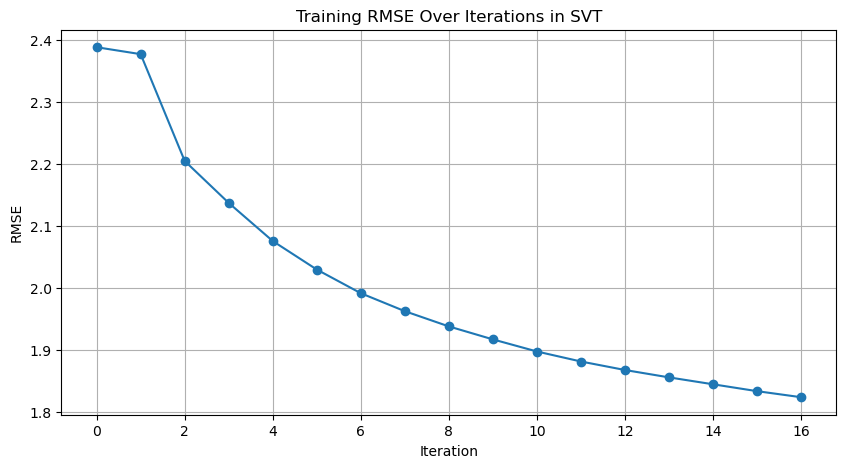

In [13]:

param_grid = {
    # 'cut_off': [10**i for i in range(-5, 5)],  # different ranks to test
    # 'step_size': [0.1, 0.5, 1, 1.5, 2],
    'cut_off': [100],
    'step_size': [1.5],
    'epsilon': [0.01]  # can include different epsilon values if needed
}

algorithm = 'svt'
# best_params, best_score = cross_validate(train_ratings_matrix, algorithm, param_grid, num_folds=5)

# print(f"Best Parameters: {best_params}")
# score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, algorithm, return_train=True, **best_params)

score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, algorithm, return_train=True, step_size=1.5, cut_off=100)
print(f"SVT RMSE: {score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in SVT')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()


Iteration 33, RMSE: 0.9563192320621066
SVP RMSE: 1.517453759629722


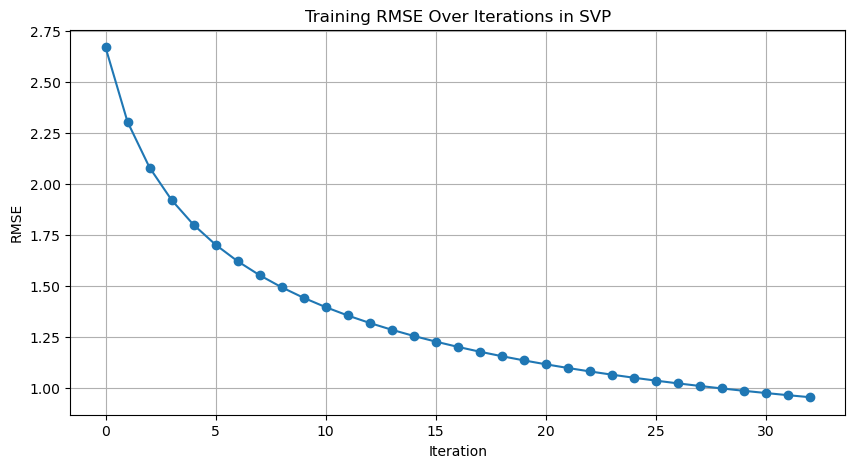

In [14]:

test_score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, 'svp', return_train=True, rank=significant_rank)
print(f"SVP RMSE: {test_score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in SVP')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Iteration 9, RMSE: 1.2264543729546622, Relative Error: 0.33564530287172746
ADMiRA RMSE: 1.6464707200312585


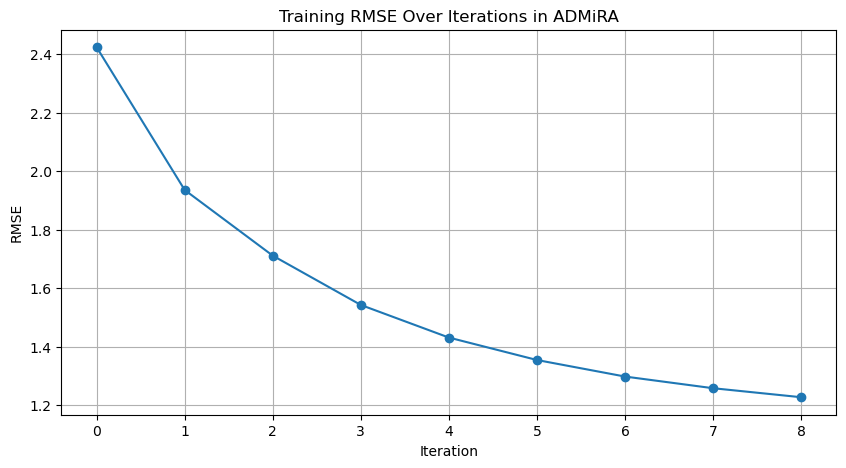

In [15]:
test_score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, 'admira', return_train=True, rank=significant_rank)
print(f"ADMiRA RMSE: {test_score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in ADMiRA')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# 4. Conclusion
Compare the results (RMSE, computational time) with the 3 approaches. Conclude about the best approach to keep in your
example and give potential limits on the methodologies.

- **Singular Value Projection (SVP)** achieved a better RMSE of 1.517 in a shorter time of approximately 7 seconds.
- **Singular Value Thresholding (SVT)** provided an RMSE of 1.959 in approximately 12 seconds.
- **ADMiRA** resulted in an RMSE of 1.646 but took significantly longer, about 1 minute and 15 seconds.

### Conclusion:
**Singular Value Projection (SVP)** is the most efficient method in this comparison, with an RMSE of 1.517 in about 7 seconds. SVP's strength lies in its direct approach to minimizing the reconstruction error by iteratively updating the matrix towards a fixed rank approximation. This method's performance is superior due to its straightforward approach, which results in better RMSE performance and faster computational speed.

**Singular Value Thresholding (SVT)** delivered an RMSE of 1.959 over a computation time of 12 seconds. The approach introduces a soft-thresholding step that modifies the singular values, improving the matrix sparsity. A poorly chosen threshold can lead to either over- or under-regularization, resulting in an increased RMSE. Therefore, the optimal threshold is crucial to achieving the desired regularization level.

**ADMiRA** registered an RMSE of 1.646, taking significantly longer to compute at about 1 minute. This algorithm uses a more sophisticated technique that builds a subspace for approximating the data through a greedy algorithm. As a result, it has the potential to achieve a lower RMSE. However, the computational complexity of this method limits its applicability in situations where speed is essential or when dealing with extensive datasets. Note that the excessive computation time might be partly due to our implementation.

### Potential Limits:
It is important to note that SVT's performance greatly depends on the threshold parameter. A wrong selection could lead to undesirable RMSE outcomes. Similarly, the effectiveness of SVP may decrease if the data does not inherently favor low-rank structures or if the rank parameter is inaccurately estimated. While ADMiRA may provide lower RMSE values, its practicality could be improved by its high computational demands. This could be an issue, especially for large-scale or time-critical applications, where the benefits of using ADMiRA may not outweigh the costs of time and computational resources.

Essentially, SVP strikes a balance between speed and accuracy. However, with careful parameter tuning, SVT can also be a good option. ADMiRA should only be considered when the computational budget permits exhaustive search, and the smallest improvements in RMSE are crucial. The selection of the algorithm should take into account both the dataset properties and the computational platform used.

Lastly, the approximated low-rank matrices include values that do not fall within the valid range (0.5 to 5). Particularly, observed negative values do not seem to have a clear interpretation in the context of movie recommendations.